In [ ]:
pip install git+https://github.com/Desklop/Uk_Stemmer

  Cloning https://github.com/Desklop/Uk_Stemmer to /tmp/pip-req-build-8m0z9zu4
  Running command git clone -q https://github.com/Desklop/Uk_Stemmer /tmp/pip-req-build-8m0z9zu4


In [ ]:
pip install spark-nlp==3.4.0

  Using cached spark_nlp-3.4.0-py2.py3-none-any.whl (140 kB)
  Attempting uninstall: spark-nlp
    Found existing installation: spark-nlp 3.3.4
    Uninstalling spark-nlp-3.3.4:
      Successfully uninstalled spark-nlp-3.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nlu 3.3.1 requires spark-nlp<3.4.0,>=3.3.0, but you have spark-nlp 3.4.0 which is incompatible.


In [ ]:
pip install pyspark==3.0.2

In [ ]:
pip install nlu pyspark==3.0.2

  Using cached spark_nlp-3.3.4-py2.py3-none-any.whl (133 kB)
  Attempting uninstall: spark-nlp
    Found existing installation: spark-nlp 3.4.0
    Uninstalling spark-nlp-3.4.0:
      Successfully uninstalled spark-nlp-3.4.0


In [ ]:
!pip install pyenchant

In [ ]:
!apt-get install libenchant1c2a

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libenchant1c2a is already the newest version (1.6.0-11.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from uk_stemmer import UkStemmer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp

In [ ]:
import nlu

In [ ]:
import enchant
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(suppress=True)
nltk.download('stopwords')
nltk.download('punkt')
random_state = 8080

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
ls

drive/  sample_data/


# Basic EDA

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/full_data.csv")

In [ ]:
df.head()

,crm_customer_id,created,NAME_LOWEST
0,50081964,2021-01-25 14:21:07.610,Петлі меблеві
1,50081964,2021-01-25 14:21:07.610,Петлі меблеві
2,50081964,2021-01-29 13:53:52.920,Лотки для столових приборів
3,50081964,2021-05-31 12:21:22.080,Інсектициди
4,50081964,2021-02-20 15:02:06.730,Рейлінги для кухні


In [ ]:
df.columns = ["customer_id", "date", "category"]

In [ ]:
df.head(2)

,customer_id,date,category
0,50081964,2021-01-25 14:21:07.610,Петлі меблеві
1,50081964,2021-01-25 14:21:07.610,Петлі меблеві


In [ ]:
df.shape

(1412105, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1412105 entries, 0 to 1412104
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   customer_id  1412105 non-null  int64 
 1   date         1412105 non-null  object
 2   category     1412105 non-null  object
dtypes: int64(1), object(2)
memory usage: 32.3+ MB


In [ ]:
print(f"number of categories: {df.category.nunique()}")

number of categories: 2129


In [ ]:
print(f"number of customers: {df.customer_id.nunique()}")

number of customers: 20114


# NLP feature engineering

1. make all words lowercase
2. remove stopwords
3. preform stemming

In [ ]:
df.head()

,customer_id,date,category
0,50081964,2021-01-25 14:21:07.610,Петлі меблеві
1,50081964,2021-01-25 14:21:07.610,Петлі меблеві
2,50081964,2021-01-29 13:53:52.920,Лотки для столових приборів
3,50081964,2021-05-31 12:21:22.080,Інсектициди
4,50081964,2021-02-20 15:02:06.730,Рейлінги для кухні


In [ ]:
df.category.unique()[:20]

array(['Петлі меблеві', 'Лотки для столових приборів', 'Інсектициди',
       'Рейлінги для кухні', 'Алюмінієвий профіль', 'Стопори дверні',
       'Зубна паста', 'Куточок алюмінієвий', 'Мішки для сміття',
       'Господарчі рукавички', 'Серветки для прибирання',
       'Аератори для крана', 'Засоби для ванних кімнат', 'Швабри',
       'Засоби для кухні', 'Засоби для догляду за унітазом',
       'Клей побутовий', 'Губки господарчі', 'Пральний порошок',
       'Клей для шпалер'], dtype=object)

In [ ]:
ndf = df.drop_duplicates(subset=["customer_id", "category"])

In [ ]:
print(f"distinct records: {round((ndf.shape[0] * 100) / df.shape[0])}%")

distinct records: 38%


In [ ]:
ndf["category"] = ndf["category"].str.lower()

In [ ]:
ndf.head()

,customer_id,date,category
0,50081964,2021-01-25 14:21:07.610,петлі меблеві
2,50081964,2021-01-29 13:53:52.920,лотки для столових приборів
3,50081964,2021-05-31 12:21:22.080,інсектициди
4,50081964,2021-02-20 15:02:06.730,рейлінги для кухні
6,50081964,2021-02-20 15:02:06.730,алюмінієвий профіль


In [ ]:
sum(ndf.category.str.isnumeric())

0

In [ ]:
categories = ndf.category.unique()

In [ ]:
categories

array(['петлі меблеві', 'лотки для столових приборів', 'інсектициди', ...,
       'насоси для фонтанів', 'композитний профіль', 'дитячі шезлонги'],
      dtype=object)

In [ ]:
for category in categories:
    processed_category = [word for word in word_tokenize(category)
                              if (word not in stopwords.words("ukrainian")) and word.isalpha()]
    ndf.loc[ndf["category"] == category, "category"] = ' '.join(processed_category)

In [ ]:
ndf.head()

,customer_id,date,category
0,50081964,2021-01-25 14:21:07.610,петлі меблеві
2,50081964,2021-01-29 13:53:52.920,лотки столових приборів
3,50081964,2021-05-31 12:21:22.080,інсектициди
4,50081964,2021-02-20 15:02:06.730,рейлінги кухні
6,50081964,2021-02-20 15:02:06.730,алюмінієвий профіль


In [ ]:
categories

array(['петлі меблеві', 'лотки для столових приборів', 'інсектициди', ...,
       'насоси для фонтанів', 'композитний профіль', 'дитячі шезлонги'],
      dtype=object)

In [ ]:
categories = pd.Series(categories)
categories

0                                          петлі меблеві
1                            лотки для столових приборів
2                                            інсектициди
3                                     рейлінги для кухні
4                                    алюмінієвий профіль
                              ...                       
2124                                  домашні кінотеатри
2125    зарядні пристрої та блоки живлення для ноутбуків
2126                                 насоси для фонтанів
2127                                 композитний профіль
2128                                     дитячі шезлонги
Length: 2129, dtype: object

In [ ]:
categories.shape

(2129,)

In [ ]:
lemma_categories = nlu.load('uk.lemma').predict(categories, output_level='document')

lemma download started this may take some time.
Approximate size to download 2.3 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


In [ ]:
lemma_categories.rename({"document": "category"}, axis=1, inplace=True)

In [ ]:
lemma_categories.head()

,category,lem
0,петлі меблеві,"[петля, меблеві]"
1,лотки для столових приборів,"[лотки, для, столовий, приборів]"
2,інсектициди,[інсектициди]
3,рейлінги для кухні,"[рейлінги, для, кухня]"
4,алюмінієвий профіль,"[алюмінієвий, профіль]"


In [ ]:
ndf.head()

,customer_id,date,category
0,50081964,2021-01-25 14:21:07.610,петлі меблеві
2,50081964,2021-01-29 13:53:52.920,лотки столових приборів
3,50081964,2021-05-31 12:21:22.080,інсектициди
4,50081964,2021-02-20 15:02:06.730,рейлінги кухні
6,50081964,2021-02-20 15:02:06.730,алюмінієвий профіль


In [ ]:
ndf = ndf.merge(lemma_categories, on="category")

In [ ]:
ndf

,customer_id,date,category,lem
0,50081964,2021-01-25 14:21:07.610,петлі меблеві,"[петля, меблеві]"
1,50171691,2021-02-17 13:51:00.350,петлі меблеві,"[петля, меблеві]"
2,1600035308,2021-05-09 14:28:16.517,петлі меблеві,"[петля, меблеві]"
3,2000001033,2020-10-17 14:38:24.470,петлі меблеві,"[петля, меблеві]"
4,2000001042,2021-04-20 19:50:38.070,петлі меблеві,"[петля, меблеві]"
...,...,...,...,...
337538,33000053565,2020-10-31 10:45:18.427,спортивні лави,"[спортивний, лава]"
337539,33000056666,2021-09-15 09:38:11.600,ковані хвіртки,"[кований, хвіртка]"
337540,33000074608,2021-05-09 13:18:15.007,домашні кінотеатри,"[домашній, кінотеатр]"
337541,45002082643,2021-06-29 17:45:13.720,композитний профіль,"[композитний, профіль]"


# Applying collaborative filtering with tf-idf model

### compare cosine similarity and euclidean distance 

In [ ]:
customers_queries = ndf.set_index(["customer_id", "date"]).drop("category", axis=1)

In [ ]:
customers_queries.head()["lem"].tolist()

[['петля', 'меблеві'],
 ['петля', 'меблеві'],
 ['петля', 'меблеві'],
 ['петля', 'меблеві'],
 ['петля', 'меблеві']]

In [ ]:
customers_vs_queries = pd.DataFrame(customers_queries["lem"].tolist(), index=ndf.customer_id).stack().reset_index().pivot_table(index="customer_id", columns=0, fill_value=0, aggfunc='size')

In [ ]:
customers_vs_queries.head()

,bis,iгрові,lego,аварійний,авто,автоакустика,автодиагностики,автозапчастини,автокрісла,автомагнітоли,автомат,автоматика,автоматичний,автомобіль,автомобільний,автопилососи,автосигналізації,автотермометри,автотехнікс,автофарба,автохолодильники,автошампуні,автошини,агроволокно,адміністративний,аератори,аерозольні,акварельні,аквашузи,акрилові,аксесуари,аксесуарів,активний,акумулятори,акумуляторні,алмазна,алмазного,алмазні,алюмінієвий,анкери,...,шпаклівка,шпалери,шпателі,шпатлівка,штангенциркулі,штани,штемпельна,штора,штроборізи,штукатурка,штукатурні,штучний,шумовіброізоляція,шумівки,шурупи,шуруповерти,щебінь,щит,щоденник,щітки,ягода,яйцерізки,ємність,іграшка,ігровий,ізоляційні,ізоляція,інвентар,інвертори,індексні,індивідуальний,індикатор,іноземний,інсектициди,інсталяції,інструмент,інтерактивні,інформаційний,інфрачервоні,ґрунтовка
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50081964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
50095759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50097247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
50113709,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50116694,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
customers_vs_queries[customers_vs_queries > 0] = 1

In [ ]:
customers_vs_queries.describe()

,bis,iгрові,lego,аварійний,авто,автоакустика,автодиагностики,автозапчастини,автокрісла,автомагнітоли,автомат,автоматика,автоматичний,автомобіль,автомобільний,автопилососи,автосигналізації,автотермометри,автотехнікс,автофарба,автохолодильники,автошампуні,автошини,агроволокно,адміністративний,аератори,аерозольні,акварельні,аквашузи,акрилові,аксесуари,аксесуарів,активний,акумулятори,акумуляторні,алмазна,алмазного,алмазні,алюмінієвий,анкери,...,шпаклівка,шпалери,шпателі,шпатлівка,штангенциркулі,штани,штемпельна,штора,штроборізи,штукатурка,штукатурні,штучний,шумовіброізоляція,шумівки,шурупи,шуруповерти,щебінь,щит,щоденник,щітки,ягода,яйцерізки,ємність,іграшка,ігровий,ізоляційні,ізоляція,інвентар,інвертори,індексні,індивідуальний,індикатор,іноземний,інсектициди,інсталяції,інструмент,інтерактивні,інформаційний,інфрачервоні,ґрунтовка
count,"20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00",...,"20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00","20,066.00"
mean,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.02,0.22,0.00,0.00,0.00,0.00,0.03,0.00,0.03,0.01,0.03,0.03,0.00,0.08,0.00,0.00,0.01,0.02,0.00,0.02,0.02,0.01,0.00,0.00,0.03,0.02,0.05,...,0.08,0.12,0.11,0.01,0.00,0.00,0.00,0.08,0.00,0.05,0.03,0.03,0.02,0.01,0.14,0.01,0.00,0.00,0.03,0.05,0.00,0.00,0.06,0.02,0.08,0.09,0.02,0.01,0.00,0.01,0.00,0.00,0.00,0.03,0.00,0.03,0.01,0.00,0.00,0.11
std,0.04,0.01,0.12,0.11,0.06,0.02,0.01,0.01,0.06,0.01,0.04,0.03,0.18,0.15,0.42,0.04,0.01,0.02,0.01,0.17,0.02,0.16,0.12,0.17,0.17,0.03,0.27,0.07,0.02,0.08,0.16,0.01,0.12,0.15,0.07,0.03,0.01,0.18,0.15,0.21,...,0.27,0.32,0.32,0.09,0.06,0.04,0.04,0.28,0.01,0.21,0.17,0.17,0.15,0.09,0.34,0.12,0.06,0.06,0.17,0.23,0.06,0.06,0.24,0.13,0.27,0.29,0.15,0.08,0.05,0.09,0.02,0.02,0.01,0.16,0.05,0.17,0.09,0.01,0.06,0.32
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

In [ ]:
customers_vs_queries.to_csv("/content/drive/MyDrive/customers_vs_queries.csv")

## Apply TF-IDF model

In [ ]:
docs = list(pd.Series(ndf.lem.astype(str).unique()).apply(lambda x: x[1:-1].replace("'", "").split(', ')).values)

In [ ]:
dictionary = Dictionary(docs)

In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
corpus[:10]

[[(0, 1), (1, 1)],
 [(2, 1)],
 [(3, 1), (4, 1)],
 [(5, 1), (6, 1)],
 [(7, 1), (8, 1)],
 [(3, 1), (9, 1)],
 [(10, 1), (11, 1)],
 [(12, 1)],
 [(13, 1), (14, 1)],
 [(10, 1), (15, 1)]]

In [ ]:
tfidf = TfidfModel(corpus)

In [ ]:
[corpora for corpora in corpus][:10]

[[(0, 1), (1, 1)],
 [(2, 1)],
 [(3, 1), (4, 1)],
 [(5, 1), (6, 1)],
 [(7, 1), (8, 1)],
 [(3, 1), (9, 1)],
 [(10, 1), (11, 1)],
 [(12, 1)],
 [(13, 1), (14, 1)],
 [(10, 1), (15, 1)]]

In [ ]:
tfidf_weights = pd.DataFrame(tfidf[corpus[0]])
for corpora in corpus:
  tfidf_weights = tfidf_weights.append(pd.DataFrame(tfidf[corpora]), ignore_index=True) 

tfidf_weights

,0,1
0,0,0.64
1,1,0.77
2,0,0.64
3,1,0.77
4,2,1.00
...,...,...
2100,1267,0.80
2101,4,0.65
2102,1268,0.76
2103,118,0.33


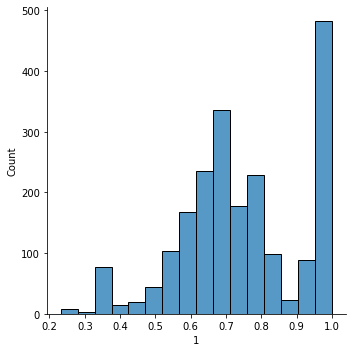

In [ ]:
sns.displot(tfidf_weights.iloc[:, 1]);

In [ ]:
(tfidf_weights.iloc[:, 1] < 1).value_counts()

True     1623
False     482
Name: 1, dtype: int64

In [ ]:
tfidf[corpus[10]]

[(16, 0.6701241729302072), (17, 0.7422490100058105)]

In [ ]:
corpus[4]

[(7, 1), (8, 1)]

In [ ]:
print(dictionary[7], dictionary[8])

зубний паста


In [ ]:
tfidf_weights.rename({0: "id", 1: "weight"}, axis=1, inplace=True)

In [ ]:
tfidf_weights.head()

,id,weight
0,0,0.64
1,1,0.77
2,0,0.64
3,1,0.77
4,2,1.00


In [ ]:
tfidf_weights = tfidf_weights.groupby("id").agg({"weight": ["max", "min", "mean"]}).reset_index()

In [ ]:
tfidf_weights.head()

id weight          
        max  min mean
0  0   0.68 0.60 0.62
1  1   0.79 0.77 0.78
2  2   1.00 1.00 1.00
3  3   0.76 0.68 0.70
4  4   0.74 0.65 0.68

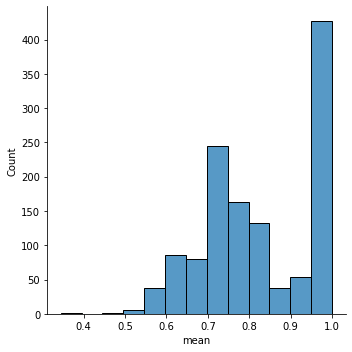

In [ ]:
sns.displot(tfidf_weights["weight"]["mean"]);

In [ ]:
tfidf_weights["id"] = tfidf_weights["id"].apply(lambda x: dictionary[x])

In [ ]:
tfidf_weights.head()

id weight          
                  max  min mean
0      меблеві   0.68 0.60 0.62
1        петля   0.79 0.77 0.78
2  інсектициди   1.00 1.00 1.00
3  алюмінієвий   0.76 0.68 0.70
4      профіль   0.74 0.65 0.68

In [ ]:
for category, weight in zip(tfidf_weights["id"], tfidf_weights["weight"]["mean"]):
  customers_vs_queries.loc[:, category] = (customers_vs_queries[category] * weight)

In [ ]:
customers_vs_queries.head()

,bis,iгрові,lego,аварійний,авто,автоакустика,автодиагностики,автозапчастини,автокрісла,автомагнітоли,автомат,автоматика,автоматичний,автомобіль,автомобільний,автопилососи,автосигналізації,автотермометри,автотехнікс,автофарба,автохолодильники,автошампуні,автошини,агроволокно,адміністративний,аератори,аерозольні,акварельні,аквашузи,акрилові,аксесуари,аксесуарів,активний,акумулятори,акумуляторні,алмазна,алмазного,алмазні,алюмінієвий,анкери,...,шпаклівка,шпалери,шпателі,шпатлівка,штангенциркулі,штани,штемпельна,штора,штроборізи,штукатурка,штукатурні,штучний,шумовіброізоляція,шумівки,шурупи,шуруповерти,щебінь,щит,щоденник,щітки,ягода,яйцерізки,ємність,іграшка,ігровий,ізоляційні,ізоляція,інвентар,інвертори,індексні,індивідуальний,індикатор,іноземний,інсектициди,інсталяції,інструмент,інтерактивні,інформаційний,інфрачервоні,ґрунтовка
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50081964,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50095759,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50097247,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.93
50113709,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50116694,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
user_to_user_sim_matrix = pd.DataFrame(
    cosine_similarity(customers_vs_queries),
    index=customers_vs_queries.index,
    columns=customers_vs_queries.index
)

In [ ]:
user_to_user_sim_matrix.head()

customer_id,50081964,50095759,50097247,50113709,50116694,50124346,50163389,50168245,50170083,50171691,50176842,50185742,800049993,800050418,800059359,1120154902,1120155204,1200032730,1200033892,1200034069,1200037122,1200042504,1200048313,1200048318,1200052047,1200053955,1200054648,1200084141,1200092862,1600035308,1600086288,1700046296,1700058131,1700061013,2000001015,2000001023,2000001033,2000001042,2000001056,2000001057,...,85100263106,85100264782,85100268956,85100269632,85100271369,85100271538,85100272974,85100273081,85100276796,85100276802,85100277631,85100279283,85100281367,85100281710,85100282133,85100282466,85100283851,85100284878,85100286893,85100287444,85100288668,85100291905,85100292323,85100292427,85100292492,85100314905,85100315599,85100316264,85100316381,85100317816,85100320089,85100321783,85100322432,85100323252,85100325531,85100327278,85100328957,85100329243,85100329312,85100330032
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50081964,1.00,0.05,0.00,0.04,0.00,0.00,0.10,0.00,0.12,0.27,0.08,0.00,0.00,0.00,0.06,0.07,0.15,0.00,0.13,0.05,0.00,0.09,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.21,0.00,0.00,0.07,0.05,0.10,0.17,0.15,0.00,...,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.10,0.06,0.04,0.00,0.03,0.06,0.00,0.00,0.07,0.00,0.16,0.00,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.05,0.00,0.00,0.06,0.16,0.00,0.00,0.00,0.22,0.00,0.00
50095759,0.05,1.00,0.00,0.02,0.12,0.03,0.07,0.00,0.36,0.20,0.08,0.14,0.10,0.00,0.09,0.08,0.04,0.00,0.09,0.14,0.00,0.20,0.00,0.00,0.10,0.11,0.07,0.00,0.00,0.17,0.00,0.16,0.10,0.08,0.08,0.18,0.23,0.13,0.11,0.07,...,0.00,0.12,0.00,0.00,0.00,0.13,0.00,0.10,0.00,0.06,0.24,0.02,0.00,0.00,0.00,0.05,0.14,0.00,0.06,0.00,0.00,0.12,0.24,0.08,0.10,0.06,0.16,0.00,0.00,0.03,0.13,0.12,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.00
50097247,0.00,0.00,1.00,0.08,0.00,0.11,0.17,0.00,0.03,0.00,0.06,0.02,0.00,0.00,0.14,0.00,0.25,0.00,0.05,0.00,0.00,0.13,0.12,0.00,0.19,0.03,0.14,0.00,0.17,0.10,0.00,0.00,0.07,0.14,0.25,0.04,0.14,0.32,0.13,0.17,...,0.11,0.18,0.00,0.16,0.00,0.32,0.11,0.07,0.00,0.00,0.21,0.11,0.13,0.07,0.22,0.00,0.02,0.00,0.10,0.04,0.00,0.10,0.12,0.14,0.03,0.10,0.08,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.11,0.12,0.06,0.00,0.20,0.00
50113709,0.04,0.02,0.08,1.00,0.16,0.20,0.11,0.00,0.00,0.11,0.22,0.05,0.11,0.00,0.05,0.00,0.09,0.10,0.00,0.07,0.19,0.08,0.00,0.09,0.16,0.23,0.04,0.22,0.12,0.14,0.00,0.03,0.17,0.11,0.04,0.13,0.22,0.15,0.08,0.00,...,0.08,0.12,0.00,0.00,0.00,0.03,0.15,0.25,0.08,0.28,0.08,0.05,0.07,0.04,0.00,0.08,0.11,0.09,0.14,0.03,0.00,0.19,0.00,0.05,0.06,0.24,0.02,0.12,0.00,0.08,0.02,0.00,0.00,0.24,0.00,0.14,0.18,0.00,0.12,0.09
50116694,0.00,0.12,0.00,0.16,1.00,0.15,0.10,0.00,0.11,0.24,0.06,0.06,0.03,0.00,0.17,0.21,0.18,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.13,0.12,0.18,0.19,0.18,0.14,0.00,0.00,0.00,0.21,0.12,0.03,0.15,0.08,0.14,0.00,...,0.00,0.19,0.00,0.05,0.00,0.02,0.11,0.07,0.00,0.14,0.00,0.06,0.11,0.00,0.17,0.14,0.00,0.14,0.14,0.00,0.00,0.09,0.00,0.00,0.12,0.15,0.23,0.20,0.00,0.11,0.04,0.06,0.00,0.08,0.00,0.20,0.09,0.00,0.03,0.19


## See and compare results

In [ ]:
user_to_user_sim_matrix.iloc[0].sort_values(ascending=False)

customer_id
50081964      1.00
33000030393   0.44
45002172157   0.43
19000031041   0.43
2000010608    0.42
              ... 
19000107828   0.00
19000107793   0.00
19000107747   0.00
19000107745   0.00
19000074125   0.00
Name: 50081964, Length: 20066, dtype: float64

In [ ]:
def compare_customers(customers: list, df: pd.DataFrame) -> None:
  plt.figure(figsize=(10, 7))
  sns.countplot(data=df[df["customer_id"].isin(customers)], y="category", hue="customer_id");
  plt.show()

In [ ]:
def find_intersection(customer_id_1: int, customer_id_2: int, df: pd.DataFrame) -> None:
  customer_1 = df[df["customer_id"] == customer_id_1]["category"] 
  customer_2 = df[df["customer_id"] == customer_id_2]["category"]
  print(pd.Series(np.intersect1d(customer_1.values, customer_2.values)))

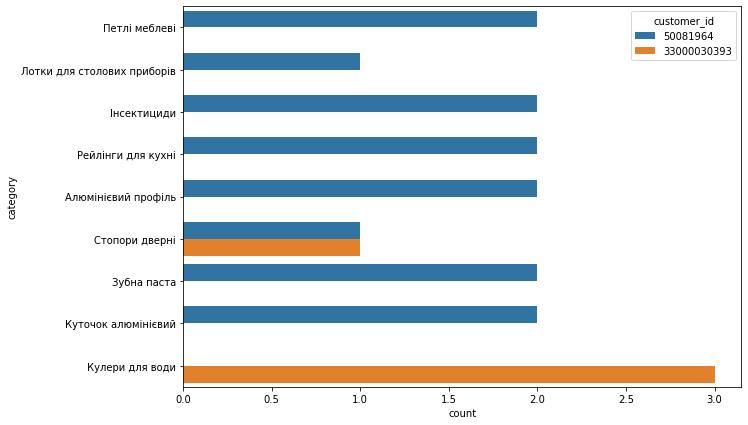

In [ ]:
compare_customers([50081964, 33000030393], df)

In [ ]:
find_intersection(50081964, 33000030393, df)

0    Стопори дверні
dtype: object


In [ ]:
user_to_user_sim_matrix.iloc[10].sort_values(ascending=False)

customer_id
50176842      1.00
2000028459    0.40
19000032529   0.39
19000035170   0.39
33000036091   0.39
              ... 
2000077180    0.00
19000123944   0.00
19000073246   0.00
2000077314    0.00
19000102210   0.00
Name: 50176842, Length: 20066, dtype: float64

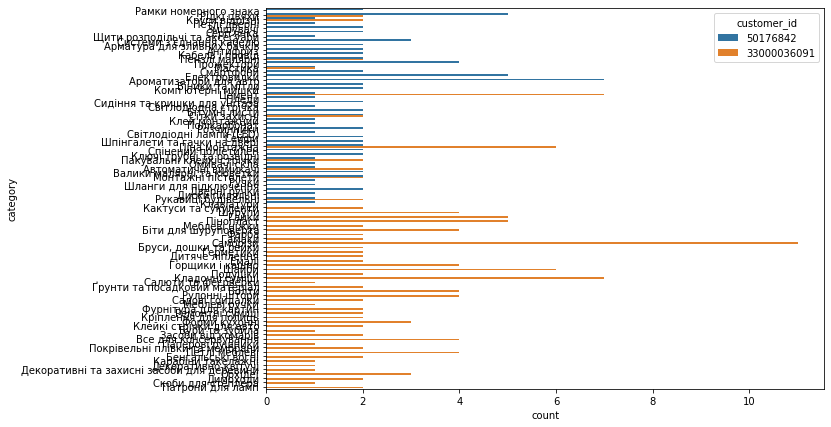

In [ ]:
compare_customers([50176842, 33000036091], df)

In [ ]:
find_intersection(50176842, 33000036091, df)

0          Автоматичні вимикачі
1                Круги відрізні
2                       Мастика
3            Монтажні пістолети
4     Пакувальні клейкі стрічки
5                Пензлі малярні
6                 Піна монтажна
7           Рукавиці будівельні
8                   Рідкі цвяхи
9                 Сітки захисні
10                       Цемент
dtype: object


In [ ]:
user_to_user_euc_matrix = pd.DataFrame(
    euclidean_distances(customers_vs_queries),
    index=customers_vs_queries.index,
    columns=customers_vs_queries.index
)

In [ ]:
user_to_user_euc_matrix.head()

customer_id,50081964,50095759,50097247,50113709,50116694,50124346,50163389,50168245,50170083,50171691,50176842,50185742,800049993,800050418,800059359,1120154902,1120155204,1200032730,1200033892,1200034069,1200037122,1200042504,1200048313,1200048318,1200052047,1200053955,1200054648,1200084141,1200092862,1600035308,1600086288,1700046296,1700058131,1700061013,2000001015,2000001023,2000001033,2000001042,2000001056,2000001057,...,85100263106,85100264782,85100268956,85100269632,85100271369,85100271538,85100272974,85100273081,85100276796,85100276802,85100277631,85100279283,85100281367,85100281710,85100282133,85100282466,85100283851,85100284878,85100286893,85100287444,85100288668,85100291905,85100292323,85100292427,85100292492,85100314905,85100315599,85100316264,85100316381,85100317816,85100320089,85100321783,85100322432,85100323252,85100325531,85100327278,85100328957,85100329243,85100329312,85100330032
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50081964,0.00,3.92,3.98,4.91,3.53,5.28,4.74,3.08,4.03,3.79,5.73,5.30,3.97,2.67,5.70,3.09,5.98,3.41,3.77,4.08,3.38,5.08,3.46,3.07,5.85,4.68,4.82,4.39,3.11,5.92,2.73,2.74,4.89,4.42,6.03,4.59,8.11,4.89,5.86,3.54,...,2.93,3.51,2.73,3.01,2.73,4.91,3.75,4.69,3.64,5.28,4.30,6.57,4.03,2.97,3.24,3.20,4.97,3.34,4.08,3.15,2.89,5.46,3.51,4.74,4.17,5.73,3.94,3.02,2.54,4.10,3.41,2.84,3.37,3.23,2.79,4.64,4.21,2.73,4.38,3.23
50095759,3.92,0.00,4.60,5.46,3.96,5.68,5.26,3.84,3.89,4.41,6.10,5.38,4.36,3.52,6.00,3.79,6.59,4.10,4.40,4.41,4.09,5.18,4.15,4.08,6.00,4.91,5.14,4.95,3.86,6.13,3.56,3.56,5.14,4.77,6.38,4.73,7.91,5.36,6.29,4.06,...,3.72,3.95,3.56,3.78,3.56,5.24,4.39,5.16,4.39,5.67,4.25,6.96,4.74,3.75,3.96,3.93,5.08,4.29,4.54,3.90,3.68,5.83,3.67,5.06,4.51,6.00,4.56,3.79,3.42,4.69,3.84,3.47,3.91,4.19,3.61,5.18,4.33,3.83,4.94,3.96
50097247,3.98,4.60,0.00,5.27,4.17,5.43,4.95,3.80,4.74,4.90,6.13,5.69,4.55,3.48,5.85,3.91,5.95,4.07,4.47,4.73,4.05,5.37,3.86,4.05,5.71,5.10,4.93,4.92,3.52,6.33,3.52,3.81,5.18,4.61,5.83,5.09,8.18,4.78,6.20,3.83,...,3.50,3.77,3.52,3.47,3.52,4.67,4.12,5.21,4.36,5.82,4.31,6.66,4.39,3.59,3.51,4.00,5.38,4.26,4.40,3.79,3.65,5.86,3.91,4.87,4.65,5.87,4.76,3.76,3.38,4.53,4.07,3.61,4.13,4.16,3.41,4.84,4.63,3.80,4.41,3.92
50113709,4.91,5.46,5.27,0.00,4.78,5.78,5.86,4.86,5.69,5.44,6.18,6.34,5.16,4.61,6.75,4.95,7.02,4.86,5.50,5.44,4.64,6.20,5.11,4.86,6.40,5.27,5.99,5.12,4.64,6.75,4.65,4.81,5.62,5.47,7.09,5.60,8.26,5.94,6.97,5.16,...,4.63,4.86,4.65,4.82,4.65,6.26,4.94,5.37,5.11,5.57,5.48,7.46,5.40,4.73,4.96,4.84,5.90,5.01,5.15,4.85,4.74,6.18,5.15,5.88,5.46,5.97,5.76,4.61,4.54,5.40,5.03,4.71,5.12,4.58,4.68,5.53,5.14,4.86,5.41,4.78
50116694,3.53,3.96,4.17,4.78,0.00,5.07,4.87,3.32,4.22,4.00,5.89,5.32,4.10,2.95,5.54,3.06,5.99,3.63,3.96,4.36,3.60,5.42,3.68,3.60,5.67,4.57,4.56,4.13,3.03,6.00,3.00,3.33,5.05,4.11,6.01,4.79,8.04,5.20,5.98,3.75,...,3.19,3.36,3.00,3.18,3.00,5.20,3.73,4.90,3.94,5.17,4.48,6.60,4.09,3.22,3.16,3.29,5.13,3.56,3.96,3.39,3.14,5.63,3.73,4.90,4.09,5.49,4.07,2.95,2.83,4.13,3.56,3.02,3.70,3.57,3.05,4.35,4.20,3.32,4.49,3.12


In [ ]:
user_to_user_euc_matrix.iloc[1].sort_values().head()

customer_id
50095759      0.00
19000089256   2.82
62000010675   2.85
33000064649   2.91
19000106444   2.92
Name: 50095759, dtype: float64

In [ ]:
user_to_user_sim_matrix.iloc[1].sort_values(ascending=False).head()

customer_id
50095759      1.00
62000010675   0.52
19000089256   0.52
19000122730   0.51
33000078533   0.49
Name: 50095759, dtype: float64

In [ ]:
find_intersection(50095759, 19000089256, df)

0                 Аератори для крана
1               Господарчі рукавички
2                   Губки господарчі
3           Засоби для ванних кімнат
4     Засоби для догляду за унітазом
5                   Засоби для кухні
6             Засоби для миття вікон
7            Засоби для миття посуду
8                   Мішки для сміття
9                   Пральний порошок
10           Серветки для прибирання
11         Універсальні миючі засоби
dtype: object


In [ ]:
find_intersection(50095759, 62000010675, df)

0              Господарчі рукавички
1                  Губки господарчі
2          Засоби для ванних кімнат
3    Засоби для догляду за унітазом
4                  Засоби для кухні
5            Засоби для миття вікон
6                  Мішки для сміття
7           Серветки для прибирання
8         Універсальні миючі засоби
9                            Швабри
dtype: object


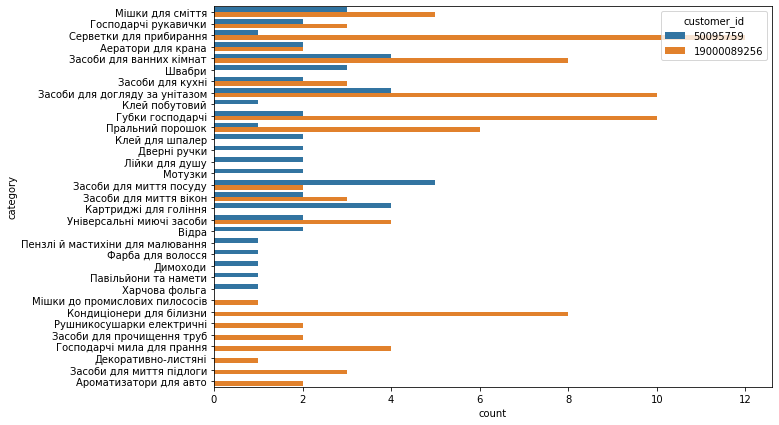

In [ ]:
compare_customers([50095759, 19000089256], df)

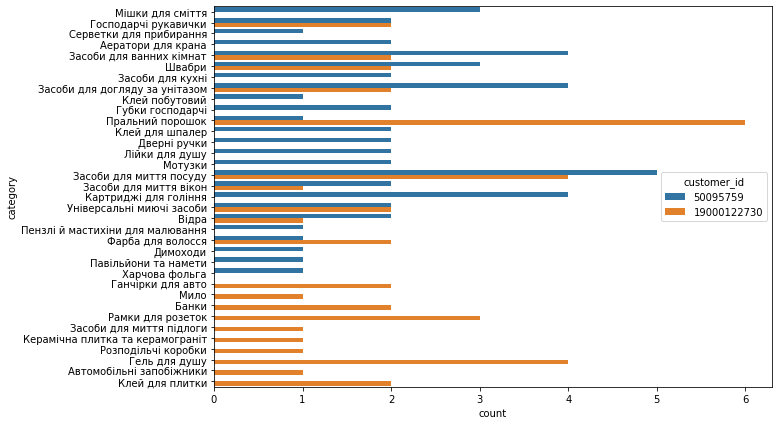

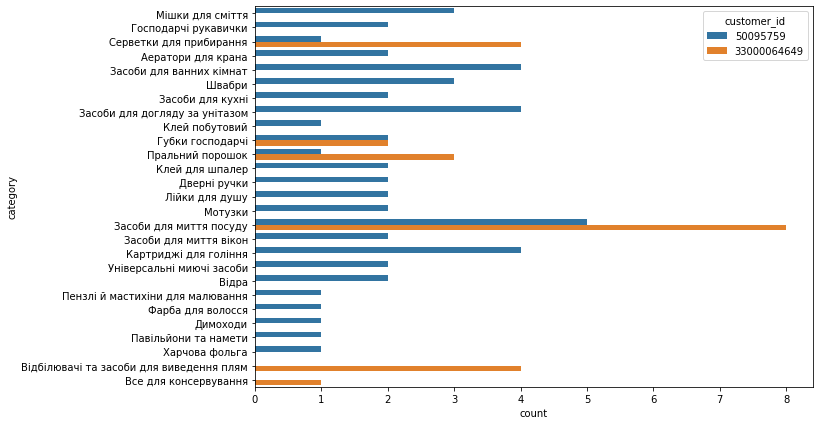

In [ ]:
compare_customers([50095759, 19000122730], df)
compare_customers([50095759, 33000064649], df)